In [ ]:
! pip install opendatasets

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import opendatasets as od
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
#OPTIMIZER
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import keras
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [ ]:
od.download('https://www.kaggle.com/datasets/ruizgara/socofing')

Skipping, found downloaded files in "./socofing" (use force=True to force download)


In [ ]:
def pathing_export(input_list,empty_one,empty_two):
    
    for img_path in input_list:
        main_path,document_type = os.path.splitext(img_path)
        ID_pathing,other_type = main_path.split("__")
        _,rotation_path,finger_ID,_ = other_type.split("_")
        empty_one.append(img_path)
        empty_two.append(f"{rotation_path}_{finger_ID}")

In [ ]:
Main_Real_Data = Path("/content/socofing/SOCOFing/Real")

In [ ]:
BMP_Path = []
BMP_Labels = []

BMP_All_List = list(Main_Real_Data.glob(r"*.BMP"))
pathing_export(BMP_All_List,BMP_Path,BMP_Labels)

In [ ]:
BMP_Path_Series = pd.Series(BMP_Path,name="BMP").astype(str)
BMP_Labels_Series = pd.Series(BMP_Labels,name="CATEGORY")

In [ ]:
Main_Finger_Data = pd.concat([BMP_Path_Series,BMP_Labels_Series],axis=1)

In [ ]:
print(Main_Finger_Data.head(-1))

                                                    BMP      CATEGORY
0     /content/socofing/SOCOFing/Real/111__M_Right_m...  Right_middle
1     /content/socofing/SOCOFing/Real/63__M_Right_th...   Right_thumb
2     /content/socofing/SOCOFing/Real/426__M_Left_th...    Left_thumb
3     /content/socofing/SOCOFing/Real/351__M_Right_i...   Right_index
4     /content/socofing/SOCOFing/Real/559__M_Right_r...    Right_ring
...                                                 ...           ...
5994  /content/socofing/SOCOFing/Real/72__M_Left_rin...     Left_ring
5995  /content/socofing/SOCOFing/Real/486__M_Right_i...   Right_index
5996  /content/socofing/SOCOFing/Real/464__M_Left_in...    Left_index
5997  /content/socofing/SOCOFing/Real/575__M_Left_li...   Left_little
5998  /content/socofing/SOCOFing/Real/35__M_Left_rin...     Left_ring

[5999 rows x 2 columns]


In [ ]:
Transformation_Data = []

for IMG_X in Main_Finger_Data["BMP"]:
    x_IMG = cv2.imread(IMG_X)
    x_IMG = cv2.resize(x_IMG,(120,120))
    x_IMG = x_IMG / 255.
    Transformation_Data.append(x_IMG)

In [ ]:
print(Transformation_Data[3].shape)

(120, 120, 3)


In [ ]:
Training_Set = np.asarray(Transformation_Data)
Training_Set = Training_Set.reshape(-1,120,120,3)

In [ ]:
print(Training_Set.shape)

(6000, 120, 120, 3)


In [ ]:
Generator_Input = keras.Input(shape=(180,))

x = layers.Dense(120*60*60)(Generator_Input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((60,60,120))(x)

x = layers.Conv2D(256,4,padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,4,padding="same",strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256,4,padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,3,padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,3,padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(3,7,padding="same",activation="tanh")(x)

In [ ]:
Generator = keras.models.Model(Generator_Input,x)

In [ ]:
print(Generator.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 dense (Dense)               (None, 432000)            78192000  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 432000)            0         
                                                                 
 reshape (Reshape)           (None, 60, 60, 120)       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 256)       491776    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60, 60, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 120, 120, 256)    104883

In [ ]:
Discriminator_Input = layers.Input(shape=(120,120,3))

x = layers.Conv2D(128,3)(Discriminator_Input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,3,strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dense(1,activation="sigmoid")(x)

In [ ]:
Discriminator = keras.models.Model(Discriminator_Input,x)

In [ ]:
print(Discriminator.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 118, 118, 128)     3584      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 118, 118, 128)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 58, 128)       262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 58, 58, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 28, 28, 128)       0   

In [ ]:
Discriminator.compile(optimizer=RMSprop(lr=0.0001,clipvalue=1.0,decay=1e-8),loss="binary_crossentropy")

In [ ]:
Discriminator.trainable = False

In [ ]:
GAN_Input = keras.Input(shape=(180,))
GAN_Output = Discriminator(Generator(GAN_Input))

In [ ]:
GAN_Model = keras.models.Model(GAN_Input,GAN_Output)

In [ ]:
GAN_Model.compile(optimizer=RMSprop(lr=0.0001,clipvalue=1.0,decay=1e-8),loss="binary_crossentropy")

In [ ]:
print(GAN_Model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180)]             0         
                                                                 
 model (Functional)          (None, 120, 120, 3)       81999235  
                                                                 
 model_1 (Functional)        (None, 1)                 942593    
                                                                 
Total params: 82,941,828
Trainable params: 81,999,235
Non-trainable params: 942,593
_________________________________________________________________
None


In [ ]:
os.mkdir("new_doc_Two")

In [ ]:
start_period = 0
batch_size = 32
dim_shape = 180
iterations = 1000

for step in range(iterations):
    random_noise_vector = np.random.normal(size=(batch_size,dim_shape))
    Generator_Images = Generator.predict(random_noise_vector)
    
    stop = start_period + batch_size
    
    Real_Images = Training_Set[start_period:stop]
    
    Combination_Images = np.concatenate([Generator_Images,Real_Images])
    
    labels = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
    labels = labels + 0.005 * np.random.random(labels.shape)
    
    D_Loss = Discriminator.train_on_batch(Combination_Images,labels)
    
    random_noise_vector = np.random.normal(size=(batch_size,dim_shape))
    
    Misleading_Target = np.zeros((batch_size,1))
    
    Adver_Loss = GAN_Model.train_on_batch(random_noise_vector,Misleading_Target)
    
    start_period = start_period + batch_size
    
    if start_period > len(Training_Set) - batch_size:
        start_period = 0
     
        
    if step % 10 == 0:
        GAN_Model.save_weights("DCGAN_Model_Weights.h5")
        
        print("DISCRIMINATOR LOSS: ", D_Loss)
        print("ADVERSARIAL LOSS: ", Adver_Loss)
        
        Img_X_X = image.array_to_img(Generator_Images[0] * 255., scale=False)
        Img_X_X.save(os.path.join("./new_doc_Two","FAKE" + str(step)+".png"))
        
        Img_X_X = image.array_to_img(Real_Images[0] * 255.,scale=False)
        Img_X_X.save(os.path.join("./new_doc_Two","REAL"+str(step)+".png"))

DISCRIMINATOR LOSS:  0.6886757016181946
ADVERSARIAL LOSS:  0.6929371953010559
DISCRIMINATOR LOSS:  0.5793927907943726
ADVERSARIAL LOSS:  0.6325744986534119
DISCRIMINATOR LOSS:  0.5728340744972229
ADVERSARIAL LOSS:  0.5784781575202942
DISCRIMINATOR LOSS:  0.6241536140441895
ADVERSARIAL LOSS:  0.7488752603530884
DISCRIMINATOR LOSS:  0.4245010018348694
ADVERSARIAL LOSS:  1.0044293403625488
DISCRIMINATOR LOSS:  0.30684030055999756
ADVERSARIAL LOSS:  1.0967929363250732
DISCRIMINATOR LOSS:  0.39531177282333374
ADVERSARIAL LOSS:  1.3506805896759033
DISCRIMINATOR LOSS:  0.26932671666145325
ADVERSARIAL LOSS:  1.8349807262420654
DISCRIMINATOR LOSS:  0.15999063849449158
ADVERSARIAL LOSS:  1.9417614936828613
DISCRIMINATOR LOSS:  0.19219127297401428
ADVERSARIAL LOSS:  2.0429747104644775
DISCRIMINATOR LOSS:  0.20006708800792694
ADVERSARIAL LOSS:  2.3244359493255615
DISCRIMINATOR LOSS:  0.2302786111831665
ADVERSARIAL LOSS:  2.1023683547973633
DISCRIMINATOR LOSS:  0.26264262199401855
ADVERSARIAL LOSS:

In [ ]:
Export_Out = Path("./new_doc_Two")
List_Output = list(Export_Out.glob(r"*.png"))
List_Output_Series = pd.Series(List_Output,name="PNG").astype(str)

In [ ]:
R_F_Noise = tf.random.normal(shape=[30,dim_shape])

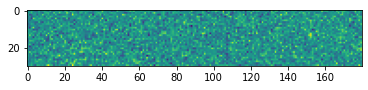

In [ ]:
plt.imshow(R_F_Noise)

In [ ]:
Generator_N_Predict = Generator(R_F_Noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

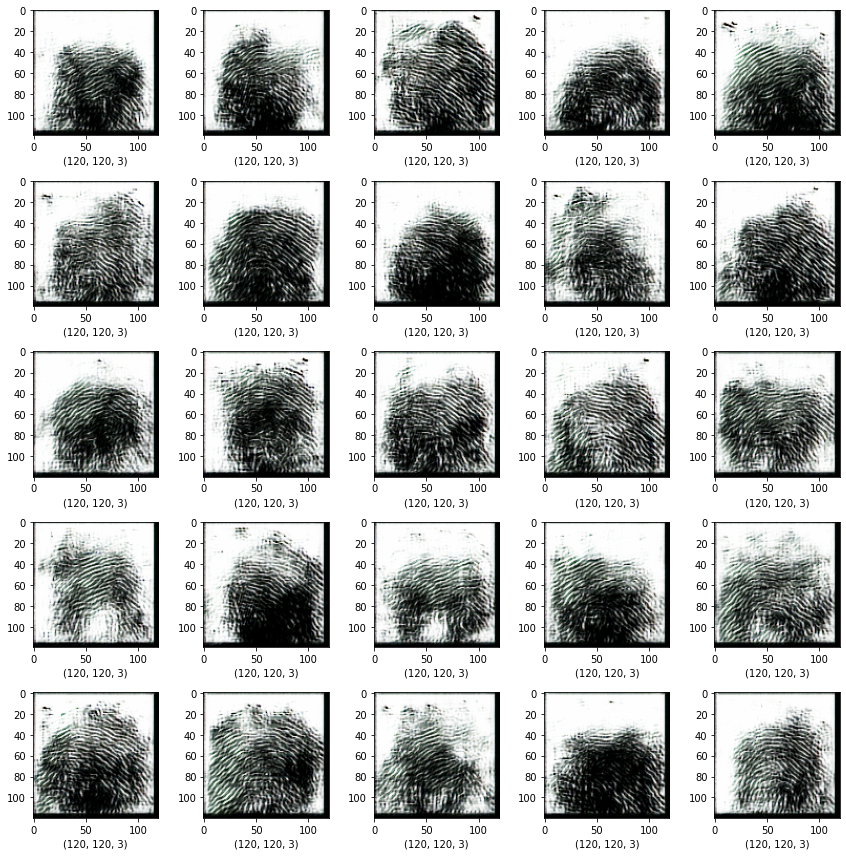

In [ ]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    IMG_F_Random = Generator_N_Predict[i]
    ax.imshow(IMG_F_Random)
    ax.set_xlabel(Generator_N_Predict[i].shape)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


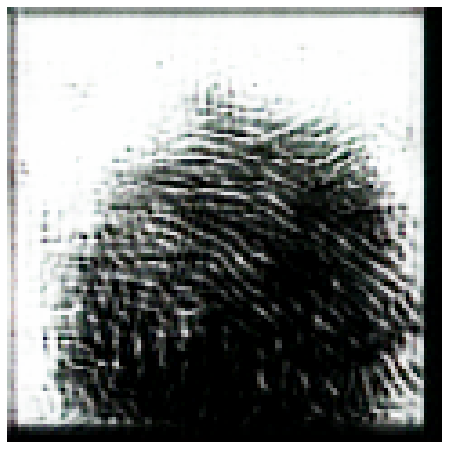

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(Generator_N_Predict[7])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


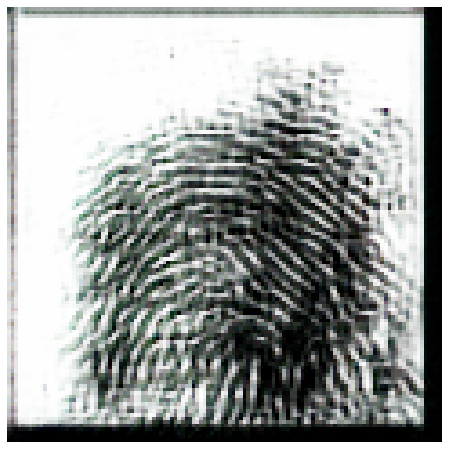

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(Generator_N_Predict[24])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


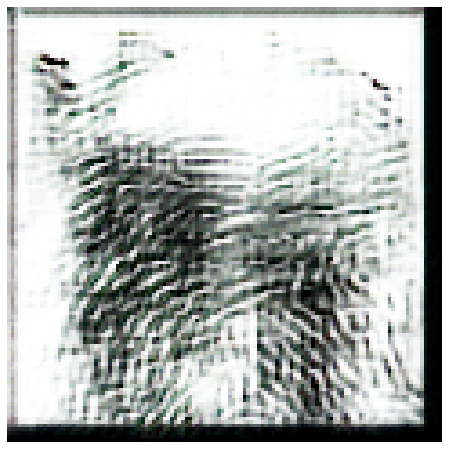

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(Generator_N_Predict[25])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


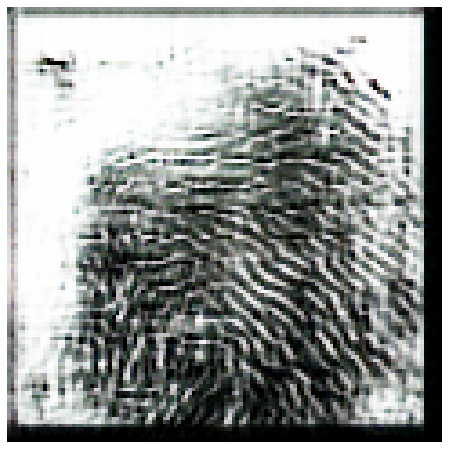

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(Generator_N_Predict[5])
plt.show()

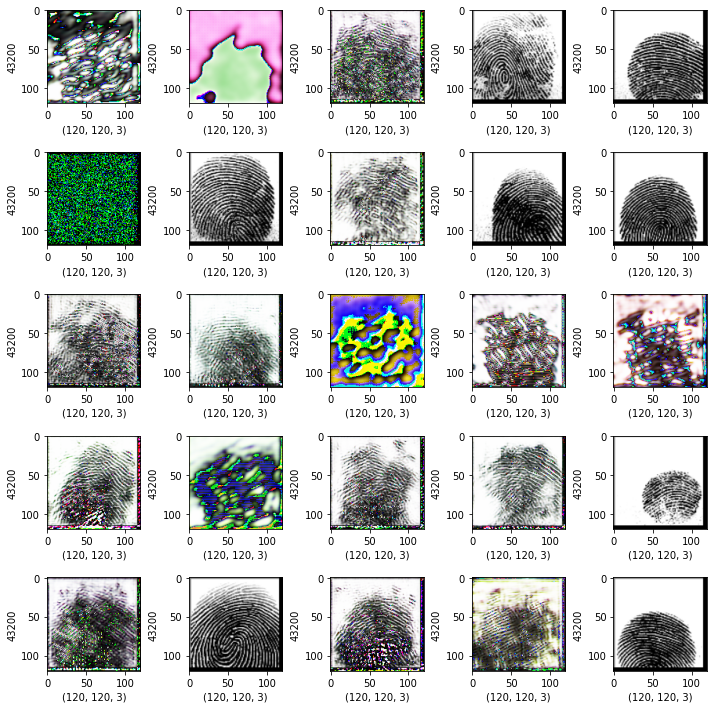

In [ ]:
figure, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10))

for i,ax in enumerate(axes.flat):
    List_Gen_Image = cv2.imread(List_Output_Series[i])
    ax.imshow(List_Gen_Image,cmap="binary")
    ax.set_xlabel(List_Gen_Image.shape)
    ax.set_ylabel(List_Gen_Image.size)
plt.tight_layout()
plt.show()

In [2]:
DISCRIMINATOR_LOSS = [0.5415801405906677,1.024383783340454,0.5872410535812378,0.6145345568656921,0.6165093183517456,0.7298857569694519,0.6168414354324341,0.6106467247009277,0.587430477142334,0.5782541036605835,0.5764140486717224,0.5991247892379761,0.6379765272140503,0.6640899181365967,0.6698306798934937,0.6126760244369507,0.6956183910369873,0.7880019545555115,0.6653569936752319,0.5715056657791138,0.6361232995986938,0.6475187540054321,0.6163253784179688,0.7554527521133423,0.6175230741500854,0.6546182632446289,0.7264226078987122,0.67002272605896,0.7286709547042847]
ADVERSARIAL_LOSS = [1.173566222190857,0.7628793716430664,1.1816767454147339,1.224034070968628,1.05086088180542,1.8632386922836304,1.0887374877929688,0.9414756894111633,1.5158209800720215,0.9046840667724609,1.052661657333374,1.0371267795562744,0.5026671886444092,1.0954664945602417,0.5906147956848145,1.0667895078659058,1.188059687614441,1.0004780292510986,1.277641773223877,0.856429934501648,0.8120163083076477,0.7047909498214722,0.9298922419548035,0.6466391086578369,0.6752461791038513,1.3010523319244385,1.37123441696167,0.9475023746490479,1.4734200239181519]

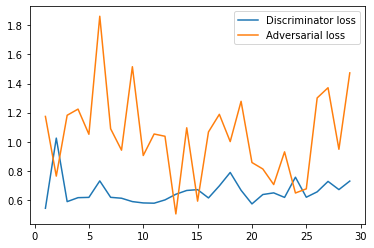

In [5]:
import matplotlib.pyplot as plt
plt.plot(list(range(1, len(DISCRIMINATOR_LOSS)+1)), DISCRIMINATOR_LOSS, label = 'Discriminator loss')
plt.plot(list(range(1, len(ADVERSARIAL_LOSS)+1)), ADVERSARIAL_LOSS, label = 'Adversarial loss')
plt.legend()